In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from nnSampleVerification import plotter, signedDistanceFunction, verify
from cnn_utils import denorm,generate_noisy_samples_from_image,img_show,logit_samples
from verif_utils import define_classification_polytope_w_b

In [46]:
betaDKW = 0.001
epsilonDKW = 0.01
Delta = 1-0.99
verifDKW = verify.usingDKW(betaDKW,epsilonDKW,Delta)
betaScenario = 0.001
verifScenario = verify.usingScenario(betaScenario,Delta)

-----------------------------------------------------------------
Error between true and empirical CDF (i.e. \sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon): epsilon = 0.01
Confidence level (i.e. P(\sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon) >= 1-\beta): 1-beta = 0.999
Number of samples needed from simulator/sampler: 38005
Please add the specification by calling "usingDKW.addSpecification()" function.
Then, add samples by calling "usingDKW.samples()" function.
-----------------------------------------------------------------
-----------------------------------------------------------------
Confidence level (i.e. P(P(g_C(f(x)) <= 0) >= 1-\Delta) >= 1-\beta): 1-beta = 0.999, 1-Delta = 0.99
Number of samples needed from simulator/sampler: 1251
Please add the specification by calling "usingScenario.addSpecification()" function.
Then, add samples by calling "usingScenario.samples()" function.
-----------------------------------------------------------------


In [ ]:
pretrained_model = "lenet_mnist_model.pth"

# Set random seed for reproducibility
torch.manual_seed(42)
# LeNet Model definition
class cnnLeNet(nn.Module):
    def __init__(self):
        super(cnnLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [48]:
# MNIST dataset and transform
mnist_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))

In [49]:
# Initialize the network
model = cnnLeNet()
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, weights_only=True))
# Set the model in evaluation mode. In this case this is for the Dropout layers: 
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './examples/Image Classification/lenet_mnist_model.pth'

In [ ]:
#load normalized image
norm_image, label = mnist_dataset[0]
norm_image = norm_image.unsqueeze(0)
print(f"Original digit: {label}")
print("---------------------------------")

Original digit: 7
---------------------------------


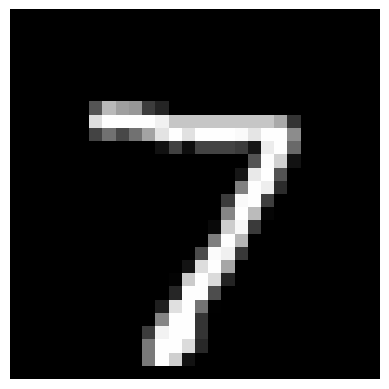

In [ ]:
#Denormalize image:
mean = torch.tensor([0.1307])
std = torch.tensor([0.3081])
image = denorm(norm_image,mean=mean, std=std)
img_show(image,save_image = True,save_name = 'original_7.png')

Number of samples needed from simulator/sampler: 38005
Number of samples needed from simulator/sampler: 1251


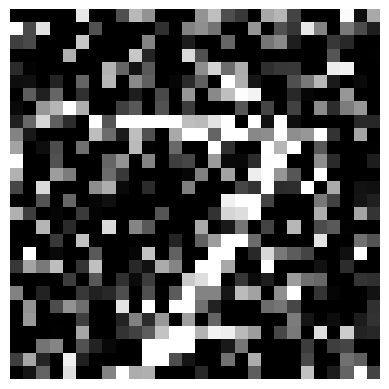

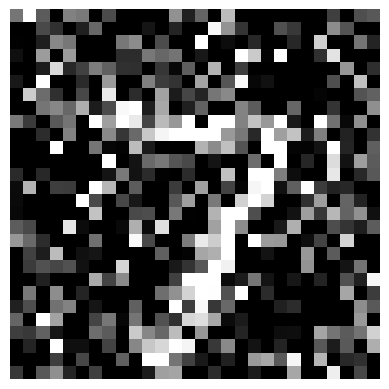

In [ ]:
#define transformation to be applied as required by nn
trans = transforms.Normalize((0.1307,), (0.3081,))
#standard deviation of noise
sd = 0.5
#generate noisy transformed images and corresponding nn output logits
noisySamplesDKW,noisyLogitsDKW = logit_samples(image,model,trans,verifDKW.samplesRequired(),sd)
noisySamplesScenario,noisyLogitsScenario = logit_samples(image,model,trans,verifScenario.samplesRequired(),sd)
img_show(denorm(noisySamplesDKW[0],mean=mean, std=std),save_image = True,save_name = 'noisy7DKW.png')
img_show(denorm(noisySamplesScenario[0],mean=mean, std=std),save_image = True,save_name = 'noisy7Scenario.png')

In [ ]:
#Defining polytope for given class index
wDKW,bDKW = define_classification_polytope_w_b(noisyLogitsDKW[0],label)
sdfDKW = signedDistanceFunction.polytope(wDKW,bDKW)
wScenario,bScenario = define_classification_polytope_w_b(noisyLogitsScenario[0],label)
sdfScenario = signedDistanceFunction.polytope(wScenario,bScenario)
verifDKW.specification(sdfDKW)
verifScenario.specification(sdfScenario)

-----------------------------------------------------------------
Specification updated. Please add samples by calling 'usingDKW.samples()' function.
----------------------------------------------------------------
-----------------------------------------------------------------
Specification updated. Please add samples by calling 'usingScenario.samples()' function.
----------------------------------------------------------------


In [ ]:
# Add the noisy samples to the verification problem: 
verifDKW.samples(noisyLogitsDKW)
verifScenario.samples(noisyLogitsScenario)

In [ ]:
# Check if the samples satisfy the specification: 
verifDKW.probability()
verifScenario.probability()

-----------------------------------------------------------------
Specification NOT satisfied as probability is 31.9773713985002% +/- 1.0% which is less than 0.99
Run "usingDKW.modifySet()" to find the scaling factor that satisfies the specification at satisfaction probability.
-----------------------------------------------------------------
-----------------------------------------------------------------
Specification NOT satisfied as scaling is 7.768492563396678 which is greater than 0
Run "usingScenario.modifySet()" to find the scaling factor that satisfies the specification at satisfaction probability.
-----------------------------------------------------------------
